In [1]:
import pandas as pd
import numpy as np
import datetime
import wf
import scipy.optimize as opm
import matplotlib.pyplot as plt

### Data Cleaning

In [2]:
df = pd.read_csv('HistoricalReturnsQA.csv')
df.index = pd.to_datetime(df['Unnamed: 0'], format = "%m/%d/%y")
df.drop(columns = 'Unnamed: 0', inplace = True)
df.index.name = ''

In [3]:
# define the invesment object as a dictionary 
inv_amt = dict({'2010-01-04': 1000, '2014-01-02': 1000, '2018-01-02': 1000})
inv_alph = dict({'2010-01-04': np.ones([1,5])/5, '2014-01-02': np.ones([1,5])/5, '2018-01-02': np.ones([1,5])/5})

# set the initial portfolio weight for each deposit
w0 = np.ones([1,5])/5

In [4]:
# Define a portfolio object, as defined in the wf.py file
Pf = wf.Portfolio(returns = df, params = 0) 

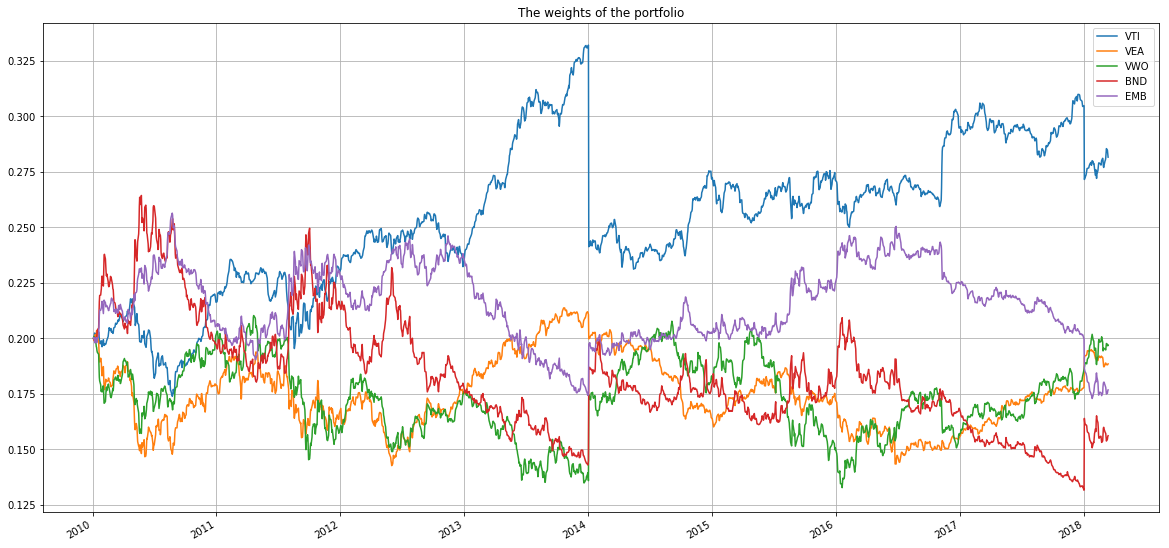

In [5]:
Pf.inv_amt = inv_amt # the amount of each investment
Pf.inv_alph = inv_alph # the weights of each investment
w_path = Pf.current_portfolio(0, w0, df, path = True) # simulate the historical path of portfolio weights
w_path.plot(figsize = (20,10), title = 'The weights of the portfolio', grid = True) # plot

### Minimization problem

Define the value of a balancing strategy as 
$$ V(\Delta x_t; s_t, p_t) = \max_{\Delta x_t} \sum_j T^{j,*} + \gamma * \sum_j |w^j_t - \bar{w}^j|^2 $$

The optimal rebalancing strategy is derived from the following optimization problem:
$$\min_{\Delta \pmb{x}_t } V(\Delta x_t; s_t, p_t) $$
subject to
$$\sum_{j=1}^N \Delta x^j = 0 $$
$$ |w^j - \bar{w}^j | \leq \kappa \quad j = 1, 2, ..., N$$
$$\Delta x^j \geq - p^j_t \sum_i \bar{s}^j_i \quad \quad j = 1, 2, ..., N$$
$$ w^j = \dfrac{p^j_t \left[\Delta^+ s^{j,*}_t + \sum_i (\bar{s}^j_{i,t} - \Delta^- s^{j,*}_{i,t}) \right]}{\sum_j p^j_t \left[\Delta^+ s^{j,*}_t + \sum_i (\bar{s}^j_{i,t} - \Delta^- s^{j,*}_{i,t}) \right]} \quad\quad j = 1, 2, ..., N $$
$$T^{j,*} = F(\Delta x^j; \bar{\pmb{s}}^j, \bar{\pmb{p}}^j) = \begin{cases}
0 &, \mbox{if } \Delta x^j > 0\\
\sum_i \tau^j_i \Delta p^j_{(i)}  \Delta s^{j,*}_{(i)} &, \mbox{if } \Delta x^j < 0
\end{cases}  $$

where $\kappa$ is a constraint on the weight of the portfolio so that the solution is not so sensitive to the choice of the parameter $\gamma$. 

In [6]:
xl = -Pf.x # lower bound of Delta x
xu = np.ones([1,5]) * np.sum(-xl); xu = xu[0] # upper bound of Delta x
wtarget = np.ones([1,5])/5; wtarget = wtarget[0]
delta_x = Pf.A * wtarget[0] + xl # the allocation if we move back to the target weight, initial guess
bounds = [z for z in zip(xl,xu)]
def cons1(x):
    return np.sum(x)
def cons2(x, kappa, rb):
    alph, xbar = rb.alph(x)
    return kappa - abs(alph - wtarget)
def sol(gamma, kappa):
    rb = wf.Rebalancing(gamma, wtarget, Pf)
    res = opm.fmin_slsqp(rb.V, delta_x, f_eqcons = cons1, f_ieqcons = lambda x: cons2(x, kappa, rb), 
                         bounds = bounds, acc = 1e-8, epsilon = 1e-8, disp = 0)
    opmx = rb.alph(res)[0]
    opmT = rb.T(res)
    return res, opmx, opmT

In [7]:
gamma = 1000
kappa = 0.05
res, opmx, opmT = sol(gamma,kappa)

In [8]:
print('The maximum deviation from the target weights: {}'.format(kappa))
print('The optimal allocation is')
print(res)
print('The optimal portfolio choice is')
print(opmx)
print('The total tax on net capital gains is')
print(opmT)

The maximum deviation from the target weights: 0.05
The optimal allocation is
[-434.29907556  195.51262483  281.34953363  693.45505385 -736.01813675]
The optimal portfolio choice is
[0.25       0.19937183 0.19937108 0.1993723  0.15188479]
The total tax on net capital gains is
-3.574036232073279


In [9]:
gamma = 1000
kappa = 0.1
res, opmx, opmT = sol(gamma,kappa)

In [10]:
print('The maximum deviation from the target weights: {}'.format(kappa))
print('The optimal allocation is')
print(res)
print('The optimal portfolio choice is')
print(opmx)
print('The total tax on net capital gains is')
print(opmT)

The maximum deviation from the target weights: 0.1
The optimal allocation is
[-1.43241235e-08 -2.18283697e+02  2.72275809e+02  6.82026025e+02
 -7.36018137e+02]
The optimal portfolio choice is
[0.27125864 0.17911678 0.19892693 0.19881286 0.15188479]
The total tax on net capital gains is
-7.115429775358135


In [11]:
gamma = 1500
kappa = 0.05
res, opmx, opmT = sol(gamma,kappa)

In [12]:
print('The maximum deviation from the target weights: {}'.format(kappa))
print('The optimal allocation is')
print(res)
print('The optimal portfolio choice is')
print(opmx)
print('The total tax on net capital gains is')
print(opmT)

The maximum deviation from the target weights: 0.05
The optimal allocation is
[-656.4819083     8.52321445   94.38036888  506.45873162   47.11959334]
The optimal portfolio choice is
[0.2391243  0.19021883 0.19021907 0.19021896 0.19021884]
The total tax on net capital gains is
4.714652070085413


Several observations:

1. As we incrase the importance of the tracking error, the tax benefit decreases. If $\kappa = 0.05$, the total tax on net capital gains increases from -3.574 to 4.714, when we increase $\gamma$ from 1000 to 1500.

2. As we relax the constraint on the maximum deviation from the target weight, the investor doesn't have to liquidate the winning stock that much and thus can achieve lower level of tax. 